In [12]:
from platform import python_version
print(python_version())

3.6.8


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [77]:
%%capture
tqdm().pandas()

# Import data

In [78]:
# import datasets

forecast1 = pd.read_csv("Data/windforecasts_wf1.csv")
forecast2 = pd.read_csv("Data/windforecasts_wf2.csv")
forecast3 = pd.read_csv("Data/windforecasts_wf3.csv")
forecast4 = pd.read_csv("Data/windforecasts_wf4.csv")
forecast5 = pd.read_csv("Data/windforecasts_wf5.csv")
forecast6 = pd.read_csv("Data/windforecasts_wf6.csv")
forecast7 = pd.read_csv("Data/windforecasts_wf7.csv")
train = pd.read_csv("Data/train.csv")
benchmark = pd.read_csv("Data/benchmark.csv")

forecasts = [forecast1, forecast2, forecast3, forecast4, forecast5, forecast6, forecast7]
# Forecast structure: date hors u v ws wd
#train structure: date wp1 wp2 wp3 wp4 wp5 wp6 wp7

In [79]:
filenames = ['wp1.csv', 'wp2.csv', 'wp3.csv', 'wp4.csv', 'wp5.csv', 'wp6.csv', 'wp7.csv']
windparks = ['wp1', 'wp2', 'wp3', 'wp4', 'wp5', 'wp6', 'wp7']

In [80]:
plot_titles = []
for i in range(7):
    plot_titles.append(f'Windfarm {i+1}')

plot_titles

['Windfarm 1',
 'Windfarm 2',
 'Windfarm 3',
 'Windfarm 4',
 'Windfarm 5',
 'Windfarm 6',
 'Windfarm 7']

# Functions

In [81]:
def plot_power_vs_direction(name, dir_series, wp_series):
    plt.scatter(dir_series, wp_series)
    plt.xlabel('Wind direction')
    plt.ylabel('Power production')
    plt.title(name)

In [82]:
# Function to remove overlapping forecasts from a forecast stored in a panda dataframe:

def remove_overlap(forecast_df):
    array = np.array([])
    r, c = forecast_df.shape
    for k in tqdm(range(forecast_df.shape[1]), desc='Removing overlap'):
        for i in range(0, forecast_df.shape[0], 48):
            for j in range(12):
                array = np.append(array, forecast_df.iloc[i+j, k])
    array2 = np.resize(array, (c, int(array.shape[0]/c)))
    fdict = {'date': array2[0].astype(int), 'hors': array2[1], 'ws': array2[4], 'wd': array2[5]}
    df = pd.DataFrame(data=fdict)
    return df

# datestring format: yyyymmddHH
def convert_to_datetime(datestring):
    day_offset = dt.timedelta(hours=24)
    # Catch change of day and give proper datetime:
    if (datestring[-2:] == '24'):
        basedate = dt.datetime.strptime(datestring[:-2], '%Y%m%d')
        adjusted_datetime_string = dt.datetime.strftime(basedate, '%Y%m%d') + '00'
        new_date = dt.datetime.strptime(adjusted_datetime_string, '%Y%m%d%H') + day_offset
    else:
        new_date = dt.datetime.strptime(datestring, '%Y%m%d%H') #''
    
    return new_date

def convert_date_format(forecast_dataframe):
    for i in tqdm(range(forecast_dataframe.shape[0]), desc='Converting date format'):
        # Fetch the date in its original format:
        prev_date = str(forecast_dataframe.iloc[i,0])
        forecast_hour = int(prev_date[-2:])
        
        # Fetch the hour the forecast is for:
        hours_ahead = int(forecast_dataframe.iloc[i,1])
        hour = str(forecast_hour + hours_ahead).zfill(2)
        
        # Replace the hours the forecast was made with the forecasted hour
        date = prev_date[:-2] + hour
        
        #append the hour the forecast is for at the end of the date:
        #date_time = date + hour
        
        forecast_dataframe.iloc[i,0] = date
    
    # Convert from string to datetime:
    forecast_dataframe['date'] = forecast_dataframe['date'].apply(convert_to_datetime) # dt.strptime(datestring, '%')
    
    # Use datetime as index:
    forecast_dataframe.set_index('date', drop=False, inplace=True, verify_integrity=True)
    
    return forecast_dataframe

def prepare_columns(forecast_df):
    forecast_df.drop(['hors'], axis=1, inplace=True)
    
    forecast_df.insert(1, 'ws-2', 0.0)
    #Date0 ws-2[1] wind_speed[2] wind_dir[3]
    forecast_df.insert(2, 'ws-1', 0.0)
    forecast_df.insert(4, 'ws+1', 0.0)
    #Date[0] ws-2[1] ws-1[2] wind_speed[3] ws+1[4] wind_dir[5]
    forecast_df.insert(5, 'wd-2', 0.0)
    forecast_df.insert(6, 'wd-1', 0.0)
    forecast_df.insert(8, 'wd+1', 0.0)

    features = ['hour_from_06', 'week', 'month']
    for feature in features:
        forecast_df.insert(forecast_df.shape[1], feature, 0)
        
    forecast_df.insert(forecast_df.shape[1], 'production', 0.0)
    
    return forecast_df

# Creation of feature: hours_from_06:
def hour_from_06(hour):
    baseline = 6
    if (hour > 12):
        return 12 - abs((hour-baseline)-12)
    return abs(hour - baseline)

# create features only for the dates we have production
def create_features(df_in, train_df, windpark):
    # Create output dataframe excluding two first rows and last (for ws-2 .. ws+1 features)
    df_out = df_in.iloc[2:-1,:].copy()
    df_out = df_out.loc[df_out['date'].isin(train_df['date'])]
    
    # Create timedeltas:
    d2 = dt.timedelta(hours=-2)
    d1 = dt.timedelta(hours=-1)
    dp1 = dt.timedelta(hours=1)

    for i in tqdm(df_out['date'], desc='Feature creation'):
        # Creating windspeed features:
        df_out.loc[i, 'ws-2'] = df_in.loc[i+d2, 'ws']
        df_out.loc[i, 'ws-1'] = df_in.loc[i+d1, 'ws']
        df_out.loc[i, 'ws+1'] = df_in.loc[i+dp1, 'ws']

        # Creating wind direction features:
        df_out.loc[i, 'wd-2'] = df_in.loc[i+d2, 'wd']
        df_out.loc[i, 'wd-1'] = df_in.loc[i+d1, 'wd']
        df_out.loc[i, 'wd+1'] = df_in.loc[i+dp1, 'wd']
        
        # Setting week number:
        df_out.loc[i, 'week'] = df_out.loc[i, 'date'].isocalendar()[1]
        
        #setting month number:
        df_out.loc[i, 'month'] = df_out.loc[i, 'date'].month
        
        # setting time from 06:00:
        df_out.loc[i, 'hour_from_06'] = hour_from_06(df_out.loc[i, 'date'].hour)
        
        # add production data (target)
        df_out.loc[i, 'production'] = train_df.loc[i, windpark]
        
    return df_out


def prepare_train_data(train):
    train_df = train.copy()
    train_df['date'] = train_df['date'].apply(str)
    train_df['date'] = train_df['date'].apply(convert_to_datetime)
    train_df.set_index('date', drop=False, inplace=True, verify_integrity=True)
    
    return train_df

def main(forecast, train, windpark, filename):
    # Convert index for train dataset:
    train_df = prepare_train_data(train)
    
    # Prepare main dataset:
    forecast_df = forecast.copy()
    forecast_df = remove_overlap(forecast_df)
    forecast_df = convert_date_format(forecast_df)
    forecast_df = prepare_columns(forecast_df)
    forecast_df = create_features(forecast_df, train_df, windpark)
    forecast_df.drop(['date'], axis=1, inplace=True)
    forecast_df.dropna(axis=0, how='any', inplace = True)
    # Write to csv file:
    forecast_df.to_csv(filename, index=True)
    
    return forecast_df

# Create datasets

In [83]:
for i in tqdm(range(len(forecasts)-1), desc='Overall progress'):
    out = main(forecasts[i], train, windparks[i], filenames[i])
    
out.head()

,ws-2,ws-1,ws,ws+1,wd-2,wd-1,wd,wd+1,hour_from_06,week,month,production
date,,,,,,,,,,,,
2009-07-01 03:00:00,4.51,4.33,4.19,4.07,135.19,135.04,134.75,134.45,3,27,7,0.013
2009-07-01 04:00:00,4.33,4.19,4.07,3.92,135.04,134.75,134.45,134.63,2,27,7,0.000
2009-07-01 05:00:00,4.19,4.07,3.92,3.69,134.75,134.45,134.63,136.00,1,27,7,0.013
2009-07-01 06:00:00,4.07,3.92,3.69,3.38,134.45,134.63,136.00,139.06,0,27,7,0.079
2009-07-01 07:00:00,3.92,3.69,3.38,3.07,134.63,136.00,139.06,142.21,1,27,7,0.013


In [87]:
# Check for missing values in last dataset:
out.loc[pd.isna(out['wd-2'])]

,ws-2,ws-1,ws,ws+1,wd-2,wd-1,wd,wd+1,hour_from_06,week,month,production
date,,,,,,,,,,,,


In [60]:
august = main(forecasts[-1], train, windparks[-1], filenames[-1])
august.head()

,ws-2,ws-1,ws,ws+1,wd-2,wd-1,wd,wd+1,hour_from_06,week,month,production
date,,,,,,,,,,,,
2009-07-01 03:00:00,4.79,4.63,4.51,4.40,139.09,140.26,140.15,139.26,3,27,7,0.000
2009-07-01 04:00:00,4.63,4.51,4.40,4.25,140.26,140.15,139.26,138.73,2,27,7,0.000
2009-07-01 05:00:00,4.51,4.40,4.25,4.00,140.15,139.26,138.73,140.00,1,27,7,0.000
2009-07-01 06:00:00,4.40,4.25,4.00,3.66,139.26,138.73,140.00,144.27,0,27,7,0.000
2009-07-01 07:00:00,4.25,4.00,3.66,3.32,138.73,140.00,144.27,149.72,1,27,7,0.025


In [121]:
august.index.dtype

dtype('<M8[ns]')

([<matplotlib.axis.XTick at 0x1c9c8643940>,
 <a list of 11 Text xticklabel objects>)

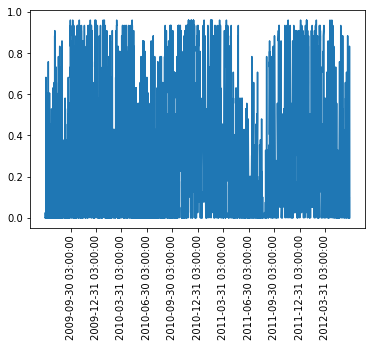

In [119]:
plt.plot(august['production'])
plt.xticks(ticks, labels=ticks, rotation=90)

In [118]:
start = august.index[0]
end =  august.index[-1]

ticks = pd.date_range(start, end, freq='Q')
ticks


DatetimeIndex(['2009-09-30 03:00:00', '2009-12-31 03:00:00',
               '2010-03-31 03:00:00', '2010-06-30 03:00:00',
               '2010-09-30 03:00:00', '2010-12-31 03:00:00',
               '2011-03-31 03:00:00', '2011-06-30 03:00:00',
               '2011-09-30 03:00:00', '2011-12-31 03:00:00',
               '2012-03-31 03:00:00'],
              dtype='datetime64[ns]', freq='Q-DEC')

,ws-2,ws-1,ws,ws+1,wd-2,wd-1,wd,wd+1,hour_from_06,week,month,production
date,,,,,,,,,,,,


,date,hors,ws,wd
date,,,,
2011-02-01 09:00:00,2011-02-01 09:00:00,9.0,3.62,242.41
2011-02-01 10:00:00,2011-02-01 10:00:00,10.0,4.22,240.34
2011-02-01 11:00:00,2011-02-01 11:00:00,11.0,4.82,239.28
2011-02-01 12:00:00,2011-02-01 12:00:00,12.0,5.21,238.57
2011-02-01 13:00:00,2011-02-01 13:00:00,1.0,5.18,230.22
2011-02-01 14:00:00,2011-02-01 14:00:00,2.0,5.26,229.28
2011-02-01 15:00:00,2011-02-01 15:00:00,3.0,5.44,228.36
2011-02-01 16:00:00,2011-02-01 16:00:00,4.0,5.63,227.58
2011-02-01 17:00:00,2011-02-01 17:00:00,5.0,5.70,227.03
